<a href="https://colab.research.google.com/github/IsitaRex/Vibe-Sorcery/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibe Sorcerer 🎼🔮  
**Summoning the perfect song for your mood, every time.**

Vibe Sorcerer is a mood-based playlist generator designed to create seamless, emotionally cohesive playlists. The core idea is simple: a great playlist isn’t just a random collection of songs—it’s a journey. By ensuring smooth transitions between tracks and maintaining a consistent emotional vibe, Vibe Sorcerer crafts playlists that feel intentional and immersive.


**Steps:**
1. Choose a song
2. Use MTG Listening Models to identify the most relevant moods of the song
3. Generate a caption of the song based on the mood
4. Generate a song based on the caption of the previous song
5. Repeat the process until you have your desired number of songs for the playlist

In [1]:
!pip3 install essentia-tensorflow
!pip3 install transformers
!pip3 install diffusers
!pip3 uninstall numpy -y
!pip3 install numpy==1.26.4
# Numpy < 2.0 needed for Essentia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 MB 3.1 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

## Step 1: Choose a song

In [2]:
#@markdown Upload the song into the same folder of this notebook and save it as "input_song.wav". Alternatively, modify the name of input_song variable
import librosa
import librosa.display
import IPython.display as ipd

audio_path = 'input_song.wav'
audio_data, sample_rate = librosa.load(audio_path)

ipd.Audio(audio_data, rate=sample_rate)


ModuleNotFoundError: No module named 'numpy.strings'

## Step 2: Use MTG Listening Models to identify the most relevant moods of the song

In [8]:
#@title Load the MTG Listening Models
# Essentia for tagging the music

from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
!wget https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.pb
!wget https://essentia.upf.edu/models/classification-heads/mtg_jamendo_moodtheme/mtg_jamendo_moodtheme-discogs-effnet-1.pb

embeddings_model = TensorflowPredictEffnetDiscogs(
    graphFilename="discogs-effnet-bs64-1.pb",
    output="PartitionedCall:1",
)

mood_classification_model = TensorflowPredict2D(
    graphFilename="mtg_jamendo_moodtheme-discogs-effnet-1.pb",
    output='model/Sigmoid',
)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

https://huggingface.co/riffusion/riffusion-model-v1

In [17]:
#@title Functions for Using the Listening Models

mood_tags = [
  "action", "adventure", "advertising", "background", "ballad", "calm",
  "children", "christmas", "commercial", "cool", "corporate",
  "dark", "deep", "documentary", "drama", "dramatic",
  "dream", "emotional", "energetic", "epic", "fast",
  "film", "fun", "funny", "game", "groovy",
  "happy", "heavy", "holiday", "hopeful", "inspiring",
  "love", "meditative", "melancholic", "melodic", "motivational",
  "movie", "nature", "party", "positive", "powerful",
  "relaxing", "retro", "romantic", "sad", "sexy",
  "slow", "soft", "soundscape", "space", "sport",
  "summer", "trailer", "travel", "upbeat", "uplifting"
]

def get_mood_activations_dict(wav_filepath):
  audio = MonoLoader(filename=wav_filepath, sampleRate=32000)()
  embeddings = embeddings_model(audio)
  activations = mood_classification_model(embeddings)
  activation_avs = []
  for i in range(0, len(activations[0])):
    vals = [activations[j][i] for j in range(0, len(activations))]
    # Note - this does the averaging bit
    activation_avs.append(sum(vals)/len(vals))
  activations_dict = {}
  for ind, tag in enumerate(mood_tags):
    activations_dict[tag] = activation_avs[ind]
  return activations_dict

In [18]:
def get_top_k_moods(mood_dict, k=5):
    """
    Returns the top k moods from a mood dictionary.

    Args:
        mood_dict (dict): A dictionary mapping mood tags to activation values.
        k (int, optional): The number of top moods to return. Defaults to 5.

    Returns:
        list: A list of the top k moods.
    """

    # Sort the mood dictionary by activation values in descending order
    sorted_moods = sorted(mood_dict.items(), key=lambda item: item[1], reverse=True)

    # Return the top k moods
    return [mood[0] for mood in sorted_moods[:k]]

In [ ]:
mood_dict = get_mood_activations_dict(audio_path)

In [ ]:
get_top_k_moods(mood_dict)

['dark', 'epic', 'action', 'space', 'soundscape']

## Step 3: Generate a caption of the song based on the mood

In [ ]:
# !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# pipe = pipeline("text-generation", model="openai-community/gpt3")

In [ ]:
def generate_song_caption(moods, max_new_tokens=50):
    """
    Generates a song caption based on a list of moods using GPT-2.

    Args:
        moods (list): A list of mood words (e.g., ["happy", "energetic", "nostalgic"]).
        max_new_tokens (int): Maximum number of new tokens to generate.

    Returns:
        str: The generated song caption.
    """
    # Create a natural-sounding prompt
    mood_str = ", ".join(moods)
    prompt = f"What song caption that fits the moods: {mood_str} in 3 sentences wold you use?"
    # prompt = f"Create a song caption that fits the moods: {mood_str} in 3 sentences. For example, if the song is [\"happy\", \"dreamy\"] you can have a caption like \"A sun-kissed melody drifts through the sky, where golden light dances on cotton candy clouds, and every note feels like a gentle breeze of endless joy.\".\nCaption:"

    # Generate text using the pipeline
    output = pipe(prompt, max_new_tokens=max_new_tokens, num_return_sequences=1, temperature=0.8, top_k=50, top_p=0.95, do_sample=True)

    # Extract generated text
    caption = output[0]["generated_text"].split("Caption:")[-1].strip()
    return caption

# Example Usage
moods = ['dark', 'epic', 'action']
caption = generate_song_caption(moods)
print("Generated Song Caption:", caption)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Song Caption: What song caption that fits the moods: dark, epic, action in 3 sentences wold you use?

This was one of the most interesting songs I've ever recorded. I thought it was a pretty interesting song, and that's probably what people are interested in. I'm a songwriter, and that's what I do.

We


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `Vibe Sorcery - llama` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-

In [ ]:
question_answering = pipeline("question-answering", model="EleutherAI/gpt-neo-125M")
question_answering = pipeline("text-generation", model="EleutherAI/gpt-neo-125M")

Some weights of GPTNeoForQuestionAnswering were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
moods = ['dark', 'epic', 'action']
mood_str = ", ".join(moods)
context = "I want you to assess me in the process of generating descriptions for songs. The descriptions should match the moods I will ask you to match. Also you should not generate long descriptions, just up to 3 sentences."
prompt = f"Can you generate a  song description that fits the moods: {mood_str}?"

In [ ]:
prompt

'Can you generate a  song description that fits the moods: dark, epic, action?'

In [ ]:
result = question_answering(prompt)
result

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Can you generate a  song description that fits the moods: dark, epic, action?\n\nI have a song description that I want to generate a song description that fits the moods'}]

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer from Hugging Face
model_name = "gpt2"  # You can use another model if you prefer
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

def generate_song_description(moods):
    prompt = f"Generate a song description based on the following moods: {', '.join(moods)}. "
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    # Generate the description
    outputs = model.generate(input_ids, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2)

    # Decode the generated description
    song_description = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return song_description

# Example usage
moods = ["happy", "dreamy"]
description = generate_song_description(moods)
print(description)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generate a song description based on the following moods: happy, dreamy.  This is a good way to get a sense of what mood you're in.
Happy:  ~~~
Dreamy:   ~~~~~~
Sleeping:
This mood is very important for a lot of people. It's a way of getting a feel for what's going on in your life. You can also use it to find out what your mood might be like. This is also a great way for you to know what kind of mood your body is in, and what you might feel like when you wake up. If you have a mood like this, you can use this mood to help you find your way back to


In [ ]:
text2text_generator = pipeline("text2text-generation", model = "gpt2")

Device set to use cpu
The model 'GPT2LMHeadModel' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration']

In [ ]:
text2text_generator(context + " " + prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'I want you to assess me in the process of generating descriptions for songs. The descriptions should match the moods I will ask you to match. Also you should not generate long descriptions, just up to 3 sentences. Can you generate a  song description that fits the moods: dark, epic, action?\n\nI want you to assess me in the process of generating descriptions for songs. The descriptions should'}]

In [ ]:
context + " " + prompt

'I want you to assess me in the process of generating descriptions for songs. The descriptions should match the moods I will ask you to match. Also you should not generate long descriptions, just up to 3 sentences. Can you generate a  song description that fits the moods: dark, epic, action?'

## Step 4: Generate a song based on the caption of the previous song

In [ ]:
from diffusers import DiffusionPipeline

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--riffusion--riffusion-model-v1/snapshots/8f2e752c74e8316c6eb4fdaa6598a46ce1d88af5/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--riffusion--riffusion-model-v1/snapshots/8f2e752c74e8316c6eb4fdaa6598a46ce1d88af5/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--riffusion--riffusion-model-v1/snapshots/8f2e752c74e8316c6eb4fdaa6598a46ce1d88af5/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--riffusion--riffusion-model-v1/snapshots/8f2e752c74e8316c6eb4fdaa6598a46ce1d88af5/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffu

In [ ]:
# Define your prompt
prompt = "A cheerful and upbeat melody with a tropical vibe"

# Generate the audio
# audio = pipeline(prompt=prompt)

In [ ]:
audio

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7A1A28B9C810>], nsfw_content_detected=[False])

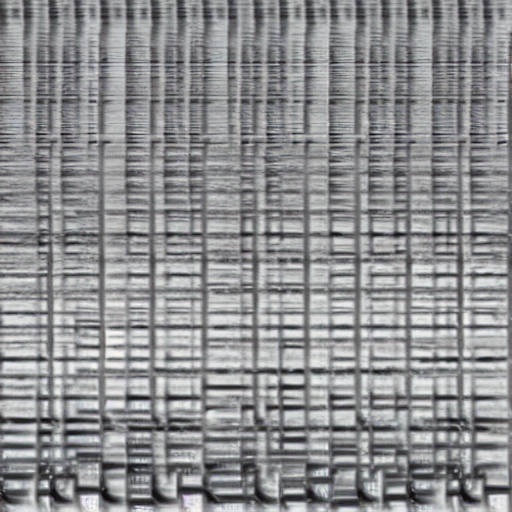

In [ ]:
audio["images"][0]

In [ ]:
type(audio["images"][0])

PIL.Image.Image

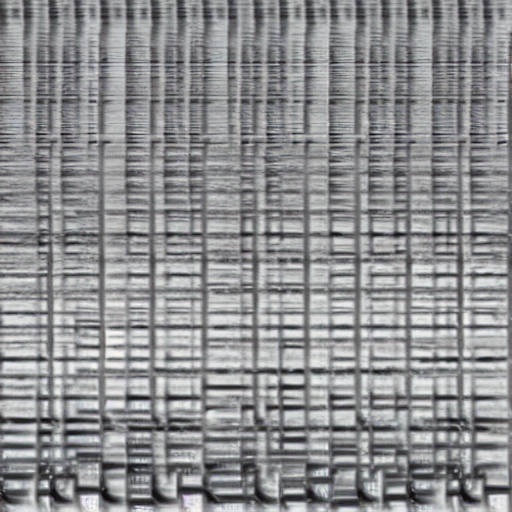

In [ ]:
audio["images"][0]

In [ ]:
img = audio["images"][0]

In [ ]:
 audio["images"][0]

SyntaxError: invalid decimal literal (<ipython-input-98-da88501820fd>, line 3)

In [ ]:
import io
import typing as T
import numpy as np
from PIL import Image
from scipy.io import wavfile
import librosa

def spectrogram_from_image(
        image: Image.Image,
        max_volume: float = 50,
        power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    """
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)
    # Flip Y take a single channel
    if len(data.shape) < 3:
        data = data[::-1]
    else:
        data = data[::-1, :, 0]
    # Invert
    data = 255 - data
    # Rescale to max volume
    data = data * max_volume / 255
    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)
    return data

def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    num_griffin_lim_iters: int = 32,
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram using librosa.
    """
    if mel_scale:
        # Convert mel spectrogram back to linear STFT
        Sxx = librosa.feature.inverse.mel_to_stft(
            Sxx,
            sr=sample_rate,
            n_fft=n_fft,
            power=1.0,
        )

    # Griffin-Lim algorithm to reconstruct the waveform
    waveform = librosa.griffinlim(
        Sxx,
        n_iter=num_griffin_lim_iters,
        hop_length=hop_length,
        win_length=win_length,
        n_fft=n_fft,
    )

    return waveform

def wav_bytes_from_spectrogram_image(
    image: Image.Image,
    duration: int,
    nmels: int,
    maxvol: int,
    power_for_image: float,
) -> T.Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    """
    max_volume = maxvol
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = duration  # [ms]

    bins_per_image = 512
    n_mels = nmels

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s

def write_bytesio_to_file(filename, bytesio):
    """
    Write the contents of the given BytesIO to a file.
    Creates the file or overwrites the file if it does
    not exist yet.
    """
    with open(filename, "wb") as outfile:
        # Copy the BytesIO stream to the output file
        outfile.write(bytesio.getbuffer())

In [ ]:
# Load a spectrogram image
image = img

# Generate WAV bytes and duration
wav_bytes, duration_s = wav_bytes_from_spectrogram_image(
    image,
    duration=5000,  # 5 seconds
    nmels=512,
    maxvol=50,
    power_for_image=0.25,
)

# Save the WAV file
write_bytesio_to_file("output.wav", wav_bytes)

print(f"Audio saved as 'output.wav' with duration {duration_s:.2f} seconds")